## ***Expected First Occurrence Time of Uncertain Future Events in One-Dimensional Linear Gaussian Systems***
#### *Annual Conference of the Prognostics and Health Management Society 2024*
##### $\bullet$ **Author:** David E. Acuña-Ureta, PhD
##### $\bullet$ **Affilitation:** Department of Mechanical and Metallurgical Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Av. Vicuña Mackenna 4860, Santiago, Chile
##### $\bullet$ **E-mail:** david.acuna@uc.cl
------------------------------------------------------------------

Libraries are imported:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

The following discrete-time one-dimensional linear Gaussian system is assumed:
$$x_{k+1} = x_k + \omega_k, \quad \omega_k\sim\mathcal{N} (0,{\sigma_{\omega}}^2),$$
denoting increasing or decreasing dynamics, depending on the value of $a$. Let us define state transition of the system as a function:

In [12]:
a = 1.03        # increasing: 1.03, decreasing: 0.95
sigma_w = 2.5   # increasing: 2.5, decreasing: 2.5

def state_transition(x):
    w = norm.rvs(0, sigma_w)
    return a*x + w

Now it can be defined a hazard zone through an uncertain event likelihood function. In the article two posible hazard zones are considered depending on the value of $a$:
$$ \mathbb{P}\left( E_k = \mathcal{E} | x_k\right) = \begin{cases}
            1 - \Phi \left( \frac{x_k - \mu_h}{\sigma_h} \right), \quad \text{if}~a<1 \\
            ~~~~\Phi \left( \frac{x_k - \mu_h}{\sigma_h} \right)~~~, \quad \text{if}~a>1 .
        \end{cases}  $$
Let us define the hazard zone as a function:

In [13]:
sigma_h = 30.0  # increasing: 30.0, decreasing: 7.0
mu_h = 300.0    # increasing: 300.0, decreasing: 25.0

def uel_function(x):
    p = norm.cdf((x - mu_h)/sigma_h)
    return 1-p if (a<1) else p

General parameters for the simulations are defined below:

In [14]:
kp = 1                      # present time
kh = 50                     # time horizon
time = np.arange(kp, kh)    # time axis
x_kp = 100.0                # initial condition
x = [x_kp]*len(time)        # storage for random state trajectories
x_mid = [x_kp]*len(time)    # expected state trajectory
x_sup = [x_kp]*len(time)    # upper confidence intervals at 95%
x_inf = [x_kp]*len(time)    # lower confidence intervals at 95%

The expected and confidence intervals (at 95% probability) of the state trajectory are computed. We know that
$$ x_k = \bar{x}_k + \bar{\omega}_k, $$
where $\bar{x}_k = a^{k-k_p}x_{k_p}$ and $\bar{\omega}_k = \sum_{n=1}^{k-k_p}a^{n-1}\omega_{k-n}$. Therefore:
$$\Rightarrow x_k\sim \mathcal{N} \left( a^{k-k_p}x_{k_p}, \sum_{n=1}^{k-k_p}a^{2(n-1)}{\sigma_{\omega}}^2 \right)$$

In [15]:
sum_a = 0
for k in range(1, len(time)):
    sum_a += a**(2*(k-1))
    x_mid[k] = (a**k)*x_kp
    x_sup[k] = x_mid[k] + 2*sigma_w*np.sqrt(sum_a)
    x_inf[k] = x_mid[k] - 2*sigma_w*np.sqrt(sum_a)

Monte Carlo simulations are performed to obtain the probability distribution of $\tau_{\mathcal{E}}$:

In [16]:
N = 10**5                           # number of Monte Carlo simulations
ToE_prob_MC = np.zeros(len(time))   # storage of histogram to approximate the actual Time-of-Event probability distribution
for i in range(N):
    prob_nE_past = 1.0
    prob_E = 0.0
    for k in range(1, len(time)):
        x[k] = state_transition(x[k-1])
        prob_E = uel_function(x[k])
        if np.random.binomial(size=1, n=1, p=prob_E)[0]:    # if the event occurs
            ToE_prob_MC[k] += 1
            break
ToE_prob_MC /= N

The mean of $\tau_{\mathcal{E}}$ is

In [17]:
mean_ToE_MC = np.average(time, weights=np.array(ToE_prob_MC))
print(mean_ToE_MC)

35.99388363898454


The probability distribution of $\bar{\tau}_{\mathcal{E}}$ is also computed. It describes what would have been the result if there was no process noise in the state transition $(\sigma_{\omega}=0)$, i.e., the result if the system would have followed its expected state trajectory:

In [18]:
ToE_prob_expected_traj = np.zeros(len(time))    # storage of the Time-of-Event probability distribution under expected state trajectory
prob_nE_past = 1.0
for k in range(1, len(time)):
    x[k] = a*x[k-1]
    prob_E = uel_function(x[k])
    ToE_prob_expected_traj[k] = prob_E*prob_nE_past
    prob_nE_past *= 1 - prob_E

The mean of $\bar{\tau}_{\mathcal{E}}$ is

In [19]:
mean_ToE_expected_traj = np.average(time, weights=np.array(ToE_prob_expected_traj))
print(mean_ToE_expected_traj)

35.81699670977934


Finally, results are plotted:

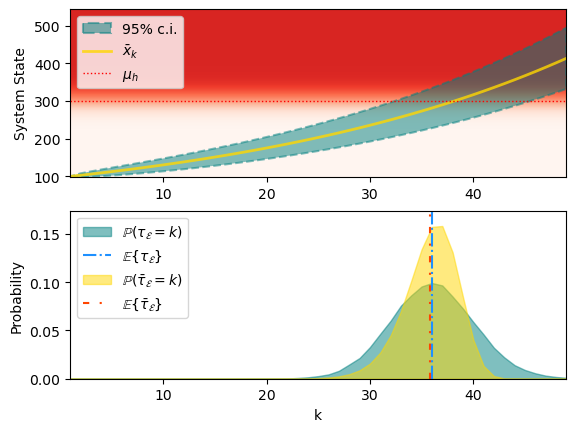

In [20]:
fig, axs = plt.subplots(2, 1)

axs[0].fill_between(time, x_inf, x_sup, color='teal', linewidth=1.5, linestyle='dashed', alpha=0.5)
axs[0].plot(time, x_mid, color='gold', linewidth=2.0, alpha=0.8)
axs[0].plot(time, mu_h*np.ones(len(time)), color='red', linestyle='dotted', linewidth=1.0)
axs[0].set_ylabel('System State')
axs[0].legend([r'95% c.i.', r'$\bar{x}_k$', r'$\mu_{h}$'])
xlim = [kp, kh-1]
ylim = [np.min(x_inf), 1.1*np.max(x_sup)]
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
delta = 0.025
pos_x = np.arange(xlim[0], xlim[1], delta)
pos_y = np.arange(ylim[1], ylim[0], -delta)
_, Y = np.meshgrid(pos_x, pos_y)
Z = 0.7*uel_function(Y)
im = axs[0].imshow(Z, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), interpolation='bicubic', cmap=plt.cm.Reds, vmin=0, vmax=1, aspect='auto')

axs[1].fill_between(time, ToE_prob_MC, color='teal', alpha=0.5)
axs[1].vlines(mean_ToE_MC, 0, 1.1*np.max([np.max(ToE_prob_expected_traj), np.max(ToE_prob_MC)]), color='dodgerblue', linestyle='dashdot')
axs[1].fill_between(time, ToE_prob_expected_traj, color='gold', alpha=0.5)
axs[1].vlines(mean_ToE_expected_traj, 0, 1.1*np.max([np.max(ToE_prob_expected_traj), np.max(ToE_prob_MC)]), color='orangered', linestyle=(0, (3, 5, 1, 5)))
axs[1].set_xlabel('k')
axs[1].set_ylabel('Probability')
axs[1].legend([r'$\mathbb{P} ( \tau _{\mathcal{E}} = k )$', r'$\mathbb{E}\{ \tau _{\mathcal{E}} \}$', r'$\mathbb{P} ( \bar{\tau} _{\mathcal{E}} = k )$', r'$\mathbb{E}\{ \bar{\tau} _{\mathcal{E}} \}$'], loc='upper left')
axs[1].set_xlim([kp, kh-1])
axs[1].set_ylim([0, 1.1*np.max([np.max(ToE_prob_expected_traj), np.max(ToE_prob_MC)])])

plt.show()